## EESC G6901 Research Computing for the Earth Sciences¶
### Final Project - December 2020
#### Name: Yuliang Sun   UNI: YS3221
#### Topic: How's Air Quality of European Countries from 2011 to 2019?

## Introduction

This report is to analyze the air quality of European countries from 2011 to 2019. 

In [19]:
import pandas as pd
import numpy as np
import xarray as xr
import cartopy
import geopandas
import matplotlib
import cartopy.crs as ccrs
from cartopy.io import shapereader
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

First of all, the dataset was downloded from [European Environment Agency (EEA) Air Quality Database](https://www.eea.europa.eu/data-and-maps/data/aqereporting-8). As the content of the downloaded dataset is beyond what I need, some data clean-up jobs were performed as follow: 

1. Some columns that would not be used in this study were dropped.
2. All of data which were not valid and have not been verified were removed from the dataset. 
3. A new column of frequency was added into the dataset. Here, the 'frequency' means how many times that a specific pollutant have been monitored in total since 2011. 
4. Some Columns were renamed for conveniences.

In [24]:
#Load data and perform data clean-up

df = pd.read_csv('EEA_airquality_full.csv')
#Drop columns that will not be used in this project
df = df.drop(columns=["UpdateTime","SamplingPointLocalId","Namespace","DataCoverage",
                      "DataCapture","TimeCoverage","BeginPosition","EndPosition"])
#Delete rows that Not valid
df = df[df.Validity != "Not valid"]
#Choose rows that are only verified
df = df[df.Verification == "Verified"]

#Add a new coloumn of frequency
df["Frequency"] = df.groupby('Pollutant')['Pollutant'].transform('count')

#Rename Columns
df.rename(columns={'CountryOrTerritory':'Country'}, inplace=True)
df.rename(columns={'SamplingPoint_Latitude':'Latitude'}, inplace=True)
df.rename(columns={'SamplingPoint_Longitude':'Longitude'}, inplace=True)

df.head()

,Country,ReportingYear,StationLocalId,Latitude,Longitude,Pollutant,AggregationType,Unit,Validity,Verification,AQValue,Frequency
5,Iceland,2012,STA-IS0030A,65.012539,-14.130437,Sulphur dioxide (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,1.492540,10931
47,Spain,2012,STA_ES1591A,42.558611,-6.725556,Ozone (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,33.447063,14754
48,Spain,2012,STA_ES1691A,39.930556,-0.603333,Ozone (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,65.331663,14754
49,Spain,2012,STA_ES1643A,41.766667,-2.466667,Ozone (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,59.629663,14754
50,Spain,2012,STA_ES1684A,41.492083,2.042497,Ozone (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,53.405302,14754


In [25]:
df.Unit.unique()

array(['ug.m-3', 'ug.l-1', 'ng.m-3', 'ppmv', 'ugNO2.m-3', 'ppbv',
       'ug.m-2.day-1', 'ng.m-2.day-1', 'ugN.m-3', 'mm', 'pHunits',
       'uS.cm-1', 'mg.l-1', 'ueH.l-1', 'ng.l-1', 'mgN.l-1', 'mgS.l-1',
       'mg.m-3', 'pg.m-3', 'ugC.m-3', 'Not specified', 'mgS.m-2.m-1',
       'mgN.m-2.m-1'], dtype=object)

The dataset has 23 different units, so some unit conversions need to be done here. Unit mg/m3 and ng/m3 were converted to ug/m3 by multiplying their relative AQValue 1000 and 1/1000 respectively. For the rest of units, I left them unchanged because the pollutants with these units have really low frequence and all of the air pollutants that I analyzed are in units of mg/m3, ug/m3, and ng/m3. After doing this, ug/m3 became the unified unit in this study. 

One more thing that needs to be clarified here is that I also assumed the unit of AQValue in France is mg/m3. I did this is particularly for the 4th analysis. Carbon Monoxide (CO) is one of the main air pollutants I analyzed in this study. However, all of CO units of France are not specified in the dataset, which makes France absent on the AQI European map. To fix this, I checked their AQValue and found the largest CO AQValue is 0.68. By comparing with other countries, I thought the most reasonable unit was mg/m3. Then, I did the same process as above.

Once the concern was solved, I created a new df without the unit of "Not specified".

In [26]:
#Unit conversion
#1. Change unit from mg.m-3 to ug.m-3 by multiplying AQValues in mg.m-3 by 1000
df.loc[df.Unit == "mg.m-3", "AQValue"] = 1000*df[df.Unit == "mg.m-3"].AQValue
df.loc[df.Unit == "mg.m-3", "Unit"] = "ug.m-3"

#2. Change unit from ng.m-3 to ug.m-3 by dividing AQValues in ng.m-3 by 1000
df.loc[df.Unit == "ng.m-3", "AQValue"] = 1/1000*df[df.Unit == "ng.m-3"].AQValue
df.loc[df.Unit == "ng.m-3", "Unit"] = "ug.m-3"

#3. For France CO 
df.loc[(df.Country == "France") & 
       (df.Unit == 'Not specified') & 
       (df.Pollutant == "Carbon monoxide (air)"), "AQValue"] = 1000*df[(df.Country == "France") & 
                                                                       (df.Unit == 'Not specified') & 
                                                                       (df.Pollutant == "Carbon monoxide (air)")].AQValue
df.loc[(df.Country == "France") & (df.Unit == 'Not specified'), "Unit"] = "ug.m-3"

#A new df without Not specified.
df_wo_ns = df[(df.Unit !='Not specified')]

### 1. Spatial distribution of monitoring stations

Let's firstly take a look at how monitoring stations distribute in Europe.

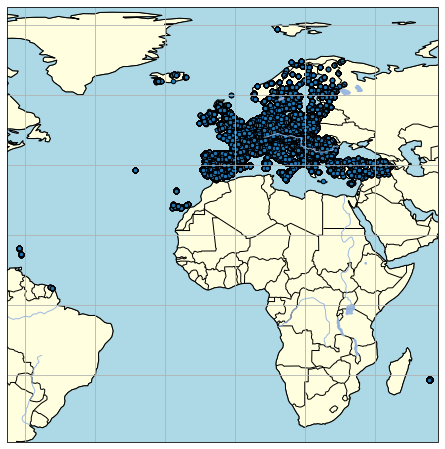

In [27]:
lat = df["Latitude"]
lon = df["Longitude"]
#central_eulat = 53.0
#central_eulon = 9.0
extent = [-65, 58, -21, 80]

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)

ax.add_feature(cartopy.feature.LAND, edgecolor='black',facecolor=('lightyellow'))
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN, edgecolor='black',facecolor=("lightblue"))
ax.add_feature(cartopy.feature.LAKES, alpha=0.95)
ax.add_feature(cartopy.feature.RIVERS, alpha=0.95)

ax.gridlines()
plt.scatter(x=lon,y=lat,s=20,edgecolors='Black',transform=ccrs.PlateCarree())
plt.show()

Monitoring stations are located amlost everywhere in Europe, even oversea regions, like the one near Madagascar. However, no stations are in Belorussia, Ukraine, and Russia. 

### 2. Analysis of annual frequency of air pollutants

To analyze the annual frequency of each air pollutant since 2011, let's take a look at how many types of air pollutants have been detected since 2011. 

In [6]:
df.Pollutant.nunique()

335

There are 335 types of air pollutants in our dataset, but most of them are very rare. Therefore, I added a new column to the dataset and reclassified those pollutants with frequency lower than 3% to "others". The other major pollutants kept their name unchanged.

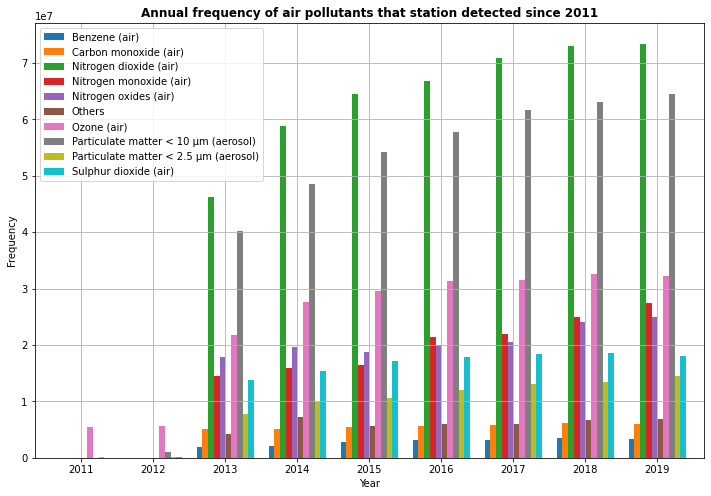

In [32]:
#Pollutants with frequency lower than 3% of all counts are defined as Others.
#Reclasify pollutants to a new column called 'Reclassified'.
df['Reclassified'] = df['Pollutant']
df.loc[df['Frequency'] <= len(df)*0.03, 'Reclassified'] = "Others"
gb_reclassified = df.groupby(["Reclassified","ReportingYear"])["Frequency"].sum()
gb_reclassified = gb_reclassified.reset_index()

gb_reclassified.pivot("ReportingYear", "Reclassified", "Frequency").plot(kind='bar',width=0.8,figsize=(12, 8))
plt.xlabel('Year')
plt.ylabel("Frequency")
plt.tick_params(axis="x", rotation=0)
plt.title("Annual frequency of air pollutants that station detected since 2011",fontweight='bold')
plt.legend()
plt.grid()
plt.show()

From the grouped bar chart, it can be known that we don't have too much data in 2011 and 2012. Ozone is the most frequent air pollutants that stations monitored in these two years. After 2012, the number of each air pollutant that were monitored has grown up. Nitrogen Dioxide (NO2) and PM10 became dominant among air pollutants that were monitored.

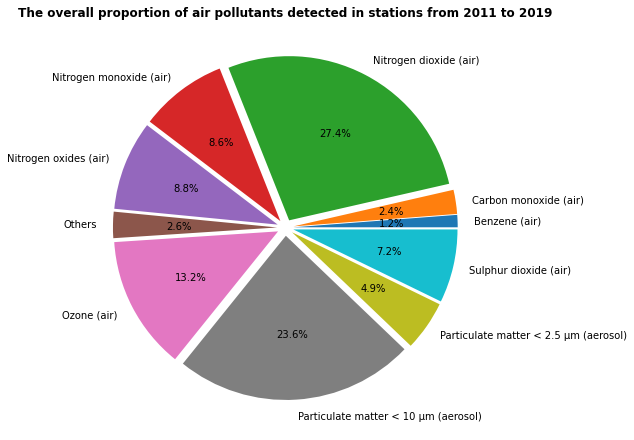

In [33]:
gb_reclassified_2011to2019 = df.groupby(["Reclassified"])["Frequency"].sum()
gb_reclassified_2011to2019tb = gb_reclassified_2011to2019.reset_index()

labels = gb_reclassified_2011to2019tb.Reclassified
explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)
plt.figure(figsize=(10, 6))
plt.pie(gb_reclassified_2011to2019tb.Frequency,explode=explode,autopct='%1.1f%%', labels=labels)
plt.tight_layout()
plt.title("The overall proportion of air pollutants detected in stations from 2011 to 2019",fontweight='bold')
plt.show()

Here's a pie chart showing the overall proportion that each air pollutant accounted for from 2011 to 2019. NO2 and PM10 are two most dominant air pollutants that were detected since 2011, followed by Ozone, NOx, and NO.

### 3. Temporal distribution of air pollutants through years

From this analysis, I will only focus on these eight major air pollutants, which are CO, SO2, Ozone, NO2, NO, PM<10, PM<2.5, and Benzene. In this part, how concentrations of major air pollutants have changed annually are discussed.  

In [34]:
gb_pollutants = df_wo_ns.groupby(["Pollutant","ReportingYear","Unit"])["AQValue"].mean()
gb_pollutants = gb_pollutants.reset_index()

CO_AQV = gb_pollutants[gb_pollutants['Pollutant'] == "Carbon monoxide (air)"]
SO2_AQV = gb_pollutants[gb_pollutants['Pollutant'] == "Sulphur dioxide (air)"]
Oz_AQV = gb_pollutants[gb_pollutants['Pollutant'] == "Ozone (air)"]
NO2_AQV = gb_pollutants[gb_pollutants['Pollutant'] == "Nitrogen dioxide (air)"]
NO_AQV = gb_pollutants[gb_pollutants['Pollutant'] == "Nitrogen monoxide (air)"]
PM10_AQV = gb_pollutants[gb_pollutants['Pollutant'] == "Particulate matter < 10 µm (aerosol)"]
PM2_5_AQV = gb_pollutants[gb_pollutants['Pollutant'] == "Particulate matter < 2.5 µm (aerosol)"]

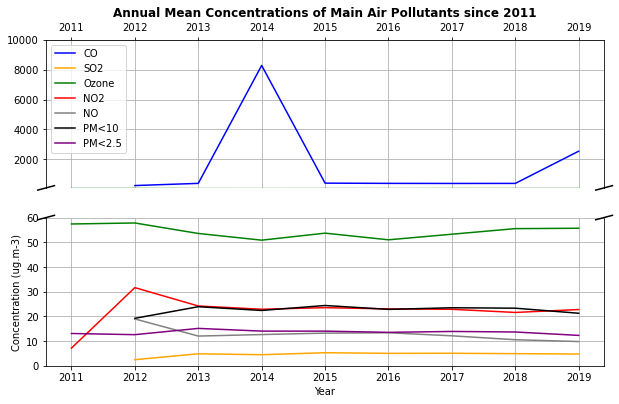

In [35]:
fig3,(ax3,ax4) = plt.subplots(2, 1, sharex=True,figsize=(10, 6))

# plot the same data on both axes
ax3.plot(CO_AQV.ReportingYear,CO_AQV.AQValue, color='blue', label = "CO")
ax3.plot(SO2_AQV.ReportingYear,SO2_AQV.AQValue, color='orange', label = "SO2")
ax3.plot(Oz_AQV.ReportingYear,Oz_AQV.AQValue, color='green',label = "Ozone")
ax3.plot(NO2_AQV.ReportingYear,NO2_AQV.AQValue, color='red',label = "NO2")
ax3.plot(NO_AQV.ReportingYear,NO_AQV.AQValue, color='grey',label = "NO")
ax3.plot(PM10_AQV.ReportingYear,PM10_AQV.AQValue, color='black',label = "PM<10")
ax3.plot(PM2_5_AQV.ReportingYear,PM2_5_AQV.AQValue, color='purple',label = "PM<2.5")

ax4.plot(CO_AQV.ReportingYear,CO_AQV.AQValue, color='blue', label = "CO")
ax4.plot(SO2_AQV.ReportingYear,SO2_AQV.AQValue, color='orange', label = "SO2")
ax4.plot(Oz_AQV.ReportingYear,Oz_AQV.AQValue, color='green',label = "Ozone")
ax4.plot(NO2_AQV.ReportingYear,NO2_AQV.AQValue, color='red',label = "NO2")
ax4.plot(NO_AQV.ReportingYear,NO_AQV.AQValue, color='grey',label = "NO")
ax4.plot(PM10_AQV.ReportingYear,PM10_AQV.AQValue, color='black',label = "PM<10")
ax4.plot(PM2_5_AQV.ReportingYear,PM2_5_AQV.AQValue, color='purple',label = "PM<2.5")

# zoom-in / limit the view to different portions of the data
ax3.set_ylim(100, 10000)  # outliers only
ax4.set_ylim(0, 60)  # most of the data

# hide the spines
ax3.spines['bottom'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax3.xaxis.tick_top()
ax3.tick_params(labeltop='off')  # don't put tick labels at the top
ax4.xaxis.tick_bottom()

d = 0.015
kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
ax3.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax3.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax4.transAxes)  # switch to the bottom axes
ax4.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax4.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax3.legend(loc='upper left')
ax3.grid()
ax4.grid()
ax4.set_xlabel('Year')
ax4.set_ylabel('Concentration (ug.m-3)')
ax3.set_title("Annual Mean Concentrations of Main Air Pollutants since 2011",fontweight='bold')
plt.show()

The line chart shows that, except for CO, most of air pollutants didn't change too much since 2011. Even though there was a small jump for NO2 in 2012 and CO in 2019, they are still acceptable. However, the most astonishing change happened in CO, which reached more than 8000 ug/m3 in 2014. I'll go deeper into this in next analysis.

### 4. AQI by countries in 2014 and why concentration of CO in 2014 is so high

To investigate the above question deeper, I want to calculate AQI (Air Quality Index) first. Once we have annual AQI of each country, we'll know a general air conditin of a specifc country throughout a specific year. According to EEA, the index is determined by the biggest AQI of severn major air pollutants, which are Carbon Monoxide (CO), Ozone (O3), Nitrogen Dioxide (NO2), Nitrogen Monoxide (NO) Sulphur Dioxide (SO2), PM2. 5 and PM10. By checking the healthy level of these air pollutants, I found that, except CO in 2014, all other air pollutants are under a healthy level from 2011 to 2019. Therefore, CO becomes the indicator of final AQI.

In [36]:
CO_2014 = df_wo_ns[(df_wo_ns['ReportingYear'] == 2014) & (df_wo_ns['Pollutant'] == "Carbon monoxide (air)")]
CO_2014_gbcountry = CO_2014.groupby("Country")["AQValue"].mean()
CO_2014_gbcountry = CO_2014_gbcountry.reset_index()
#Replace Serbia to Republic of Serbia and North Macedonia to Macedonia, 
#Otherwise they can not be highlighted on the map
CO_2014_gbcountry = CO_2014_gbcountry.replace(to_replace='Serbia', value='Republic of Serbia', regex=True)
CO_2014_gbcountry = CO_2014_gbcountry.replace(to_replace='North Macedonia', value='Macedonia', regex=True)
CO_2014_gbcountry["AQValue_ppm"] = CO_2014_gbcountry["AQValue"]*24.45/1000/28
CO_2014_gbcountry["Category"] = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,1,1,1,1]
CO_2014_gbcountry.head()

,Country,AQValue,AQValue_ppm,Category
0,Andorra,322.457000,0.281574,1
1,Austria,347.269000,0.303240,1
2,Belgium,240.058579,0.209623,1
3,Bulgaria,548.229438,0.478722,1
4,Cyprus,354.771000,0.309791,1


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


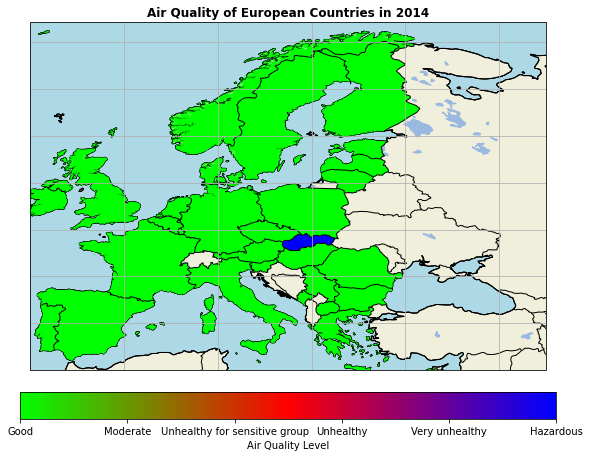

In [38]:
# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'
shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# Set up the canvas
fig = plt.figure(figsize=(12, 8))
central_lon, central_lat = 0, 45
extent = [-10, 45, 35, 70]
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.gridlines()

# Add natural earth features and borders
ax.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"),edgecolor='black')
ax.add_feature(cartopy.feature.LAND,edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, alpha=0.95)
ax.coastlines(resolution='50m')


# Insert lists of countries and Category here
countries = CO_2014_gbcountry.Country.tolist()
Cats=CO_2014_gbcountry.Category.tolist()

# Normalise the lag times to between 0 and 1 to extract the colour
Cats_norm = (Cats-np.nanmin(Cats))/(np.nanmax(Cats) - np.nanmin(Cats))

# Choose your colourmap here
cmap = matplotlib.cm.get_cmap('brg_r')

for country, lag_norm in zip(countries, Cats_norm):
    
    # read the borders of the country in this loop
    poly = df.loc[df['ADMIN'] == country]['geometry'].values[0]
    # get the color for this country
    rgba = cmap(lag_norm)
    # plot the country on a map
    ax.add_geometries([poly], crs=ccrs.PlateCarree(), facecolor=rgba, edgecolor='none', zorder=1)

# Add a scatter plot of the original data so the colorbar has the correct numbers. Hacky but it works
dummy_scat = ax.scatter(Cats, Cats, c=Cats, cmap='brg_r', zorder=0)
ax.add_feature(cartopy.feature.BORDERS,edgecolor='black')
ax.set_title('Air Quality of European Countries in 2014',fontweight='bold')

cbar = fig.colorbar(mappable=dummy_scat, label='Air Quality Level', orientation='horizontal', pad = 0.05, shrink=0.8)
cbar.ax.set_xticklabels(['Good', 'Moderate', 'Unhealthy for sensitive group', 'Unhealthy', 'Very unhealthy', 'Hazardous'])
plt.show()

Switzerland, Croatia, Bosnia and Herzegovina Norway and Albania are missing on the map because their AQValues are not valid in the dataset.

Apparently, most of European countries had very healthy air quality in 2014 (green), except one country, which is Slovakia. The air quality in Slovakia was hazardous in 2014 (blue). Therefore, I guess the very high CO concentration in 2014 was only caused by Slovakia. In other words, Slovakia itself raised the mean CO concentration in 2014. 

To prove my guess, I made another bar chart which shows the result more intuitively. 

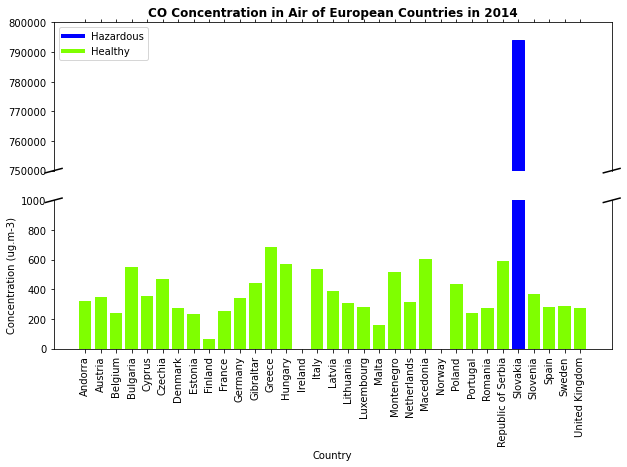

In [39]:
fig,(ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(10, 6))

# plot the same data on both axes
bar1 = ax1.bar(CO_2014_gbcountry.Country,CO_2014_gbcountry.AQValue,color='chartreuse')
bar2 = ax2.bar(CO_2014_gbcountry.Country,CO_2014_gbcountry.AQValue,color='chartreuse')

# zoom-in / limit the view to different portions of the data
ax2.set_ylim(0, 1000)  # outliers only
ax1.set_ylim(750000, 800000)  # most of the data

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax2.xaxis.tick_bottom()

d = 0.015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

bar1[-5].set_color('Blue')
bar2[-5].set_color('Blue')
ax2.set_xlabel('Country')
ax2.set_ylabel('Concentration (ug.m-3)')
ax2.set_ylabel('Concentration (ug.m-3)')
ax2.tick_params(axis="x", rotation=90)
ax1.set_title("CO Concentration in Air of European Countries in 2014",fontweight='bold')

legend_elements = [Line2D([0], [0], color='b', lw=4, label='Hazardous'),
                   Line2D([0], [0], color='chartreuse', lw=4, label='Healthy')]
ax1.legend(handles=legend_elements, loc='upper left')
plt.show()

I think this bar chart successfully proves my guess. The mean CO concentration in Slovakia reached almost 800000 ug/m3 in 2014, while the other countries were less than 800 ug/m3. I didn't believe this value at first, so I double checked the 2014 CO value of Slovakia in the original dataset. 

Here's the 2014 CO concentration of Slovakia in dataset.

In [41]:
df_wo_ns[(df_wo_ns['ReportingYear'] == 2014) &
         (df_wo_ns['Pollutant'] == "Carbon monoxide (air)") & 
         (df_wo_ns['Country'] == "Slovakia")]

,Country,ReportingYear,StationLocalId,Latitude,Longitude,Pollutant,AggregationType,Unit,Validity,Verification,AQValue,Frequency
20656,Slovakia,2014,STA-SK0047A,48.896389,18.041393,Carbon monoxide (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,548605.728,6260
21918,Slovakia,2014,STA-SK0269A,48.309456,18.076831,Carbon monoxide (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,1225996.672,6260
99705,Slovakia,2014,STA-SK0265A,48.915658,20.873901,Carbon monoxide (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,822728.506,6260
138679,Slovakia,2014,STA-SK0407A,48.436667,17.019722,Carbon monoxide (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,992219.346,6260
138680,Slovakia,2014,STA-SK0039A,49.066944,18.921947,Carbon monoxide (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,490431.875,6260
175994,Slovakia,2014,STA-SK0266A,48.993332,21.267500,Carbon monoxide (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,388181.111,6260
175995,Slovakia,2014,STA-SK0045A,48.371109,17.585018,Carbon monoxide (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,524181.492,6260
175996,Slovakia,2014,STA-SK0018A,48.592220,21.175285,Carbon monoxide (air),Annual mean / 1 calendar year,ug.m-3,Valid,Verified,1359673.069,6260


The AQValues are indeed unbelievably high in the dataset, and these data are valid and have been verified by EEA.

### 5. Mean concentration of PM2.5 from 2011 to 2019

PM2.5 is another very common air pollutant that contributes to high AQI, posing great threats to human health. Here, an addition analysis of mean concentration of PM2.5 in Europe from 2011 to 2019 was performed and the results were directly shown on the map.  

In [42]:
AQ_PM2_5 = df_wo_ns[df_wo_ns.Pollutant == "Particulate matter < 2.5 µm (aerosol)"]
gb_stationid_PM2_5_AQV = AQ_PM2_5.groupby("StationLocalId")["AQValue","Latitude","Longitude"]
gb_stationid_PM2_5_AQV_tb = gb_stationid_PM2_5_AQV.mean().reset_index()
gb_stationid_PM2_5_AQV_tb.head()

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,StationLocalId,AQValue,Latitude,Longitude
0,GIB_Station_GB0050A,13.300109,36.133317,-5.353175
1,HR_DOC_TYPE_D_STA_RH0108,10.351864,45.320794,14.483511
2,HR_DOC_TYPE_D_STA_RH0109,34.031339,45.159472,17.995100
3,HR_DOC_TYPE_D_STA_RH0111,16.291837,45.698028,18.834639
4,HR_DOC_TYPE_D_STA_RH0112,13.445680,46.169056,15.660639


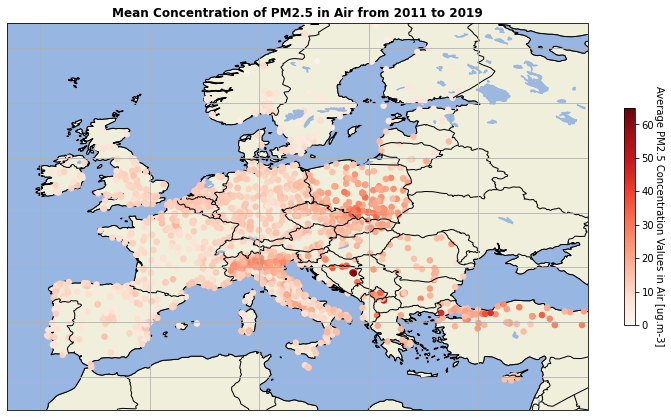

In [43]:
PM2_5_lat, PM2_5_lon = gb_stationid_PM2_5_AQV_tb['Latitude'],gb_stationid_PM2_5_AQV_tb['Longitude']
PM2_5_AQ_mean = gb_stationid_PM2_5_AQV_tb['AQValue']
eu_extent = [-13, 40, 32, 65]

fig = plt.figure(figsize=(13,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
ax1.set_extent(eu_extent)
ax1.add_feature(cartopy.feature.LAND, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS, edgecolor='black')
ax1.add_feature(cartopy.feature.OCEAN, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES, alpha=0.95)
ax1.gridlines()

pp=plt.scatter(x=PM2_5_lon,y=PM2_5_lat,c=PM2_5_AQ_mean,cmap='Reds',s=30, alpha=1,transform=ccrs.PlateCarree())
cbar=plt.colorbar(shrink=0.4)
cbar.set_label("Average PM2.5 Concentration Values in Air [ug.m-3]", labelpad=10, rotation=270)   
pp.set_clim(vmin=0, vmax=65)
plt.title("Mean Concentration of PM2.5 in Air from 2011 to 2019", fontweight='bold')
plt.show()